Author:

Tathagat Saha

Matricola: 902046

## Attention-based Recommender System

Till now we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers.

We now want to understand how we can empower our model by using the attention mechanism.

- TASK 1: Starting from the NeuMF model, think to a possible architecture for recommender system that leverage the attention mechanism (not necessarily a transformer-based architecture) and draw it. Explain how you plan to use attention and why it could enhanche your model performance.

- TASK 2: Write the Data structures (Dataset and DataLoader) needed to handle you input data. If it is necessary, rewrite the preprocessing steps and also the evaluation metrics. Always use the same rating dataset from Movielens 100k.

- TASK 3: Write the Attention-based model and train it. After finetuning, compare the performance with the best results obtained in the previous challenges.

In [ ]:
%matplotlib inline
import os
import time
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import argparse
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

# set the seed for reproducibility: built-in python, numpy, and pytorch
seed = 20
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU

class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)
  


class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)

	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)
  

dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
DATA_PATH = 'drive/MyDrive/Colab Notebooks/u.data'
MODEL_PATH = 'drive/MyDrive/Colab Notebooks/movielens_{}/'.format(num_sample_data) #change this with your directory 

#args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load data
ml_100k = pd.read_csv(
	DATA_PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')


num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1


#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=42, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=15,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--attention_layers", 
	type=int,
	default={'nhead': 4, 'num_layers': 2}, 
	help="attention dimensions in the model")
parser.add_argument("--mlp_layers",
    nargs='+', 
    default=[64,32,16],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng", 
	type=int,
	default=4, 
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", 
	type=int,
	default=100, 
	help="Number of negative samples for test set")
parser.add_argument("--out", 
	default=True,
	help="save model or not")

args = parser.parse_args("")

# construct the train and test datasets
data = NCF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()


def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)
 

# train, evaluation

def training_step(net, criterion, optimizer):
    # set the model to train mode
  running_loss=0
  net.train()
  i=0
  for user, item, label in train_loader:
    i = i + 1
    user = user.to(device)
    item = item.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    prediction = net(user, item)
    loss = criterion(prediction, label)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  return running_loss/(i)

def validation_step(net, criterion, optimizer):

    running_loss=0
    # set the model to train mode
    net.eval()
    i=0
    for user, item, label in train_loader:
      i=i+1
      user = user.to(device)
      item = item.to(device)
      label = label.to(device)
      with torch.no_grad():
        prediction = net(user, item)
        loss = criterion(prediction, label)
        running_loss+=loss.item()
    return running_loss/(i) 

def plot_loss(training_loss, validation_loss):
  plt.plot(range(len(training_loss)), training_loss, c='b', label='Loss Training')
  plt.plot(range(len(validation_loss)), validation_loss, c='r', label='Loss Validation')
  #plt.ylim(0.4, 0.8)
  plt.show()



class MultiHeadAttention(nn.Module):
    def __init__(self, args):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = args.factor_num #32
        self.num_heads = args.attention_layers['nhead'] #4
        self.head_dim = self.embedding_dim // self.num_heads #32/4=8

        self.wq = nn.Linear(self.embedding_dim, self.head_dim)#(8,8)
        self.wk = nn.Linear(self.embedding_dim, self.head_dim)#(8,8)
        self.wv = nn.Linear(self.embedding_dim, self.head_dim)#(8,8)

        self.out = nn.Linear(self.head_dim,self.embedding_dim )#(8,32)

    def forward(self, user_embeddings, item_embeddings):
        
        q = self.wq(user_embeddings)
        k = self.wk(item_embeddings)
        v = self.wv(item_embeddings)

        attention = torch.matmul(q, k.transpose(-1, -2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention = F.softmax(attention, dim=-1)

        weighted_embeddings = torch.matmul(attention, v)

        output = self.out(weighted_embeddings)

        return output

Task 1:

For this task, I am proposing two models advancements over the NeuMF model, the first one will use attention layer coded from scratch. While the 2nd model will make use of the nn.Transformer module of pytorch where a pretrained transformer is being used. Adding an attention layer will undoubtedly enhance the output performance of the existing NeuMF model, because during training the model will focus on the more important embeddings.The architechture diagram of each of them is shown below:

Model 1: An enhanced NeuMF model with Attention mechanism added from sratch. the top level architechture of this Self-Attentive NeuMF model is:

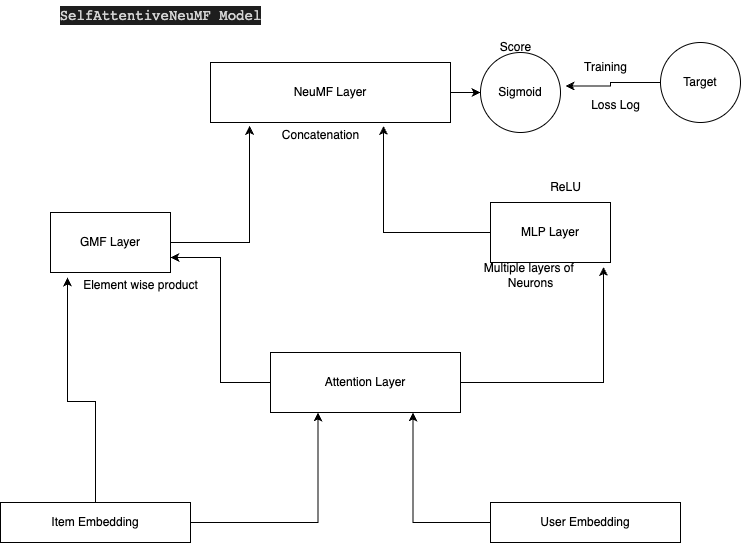

The attention layer is created as per the below architechture diagram

<center>  <img src="https://drive.google.com/uc?export=view&id=1N7XrMctFitVRKkqj_FoXs0GA_AlaVp06" width="750" height="550"> </center> 

Point to be noted here, that I have chosen:

k= user embedding

q= item embedding

v= item embedding

Below is the codification of the above layout

In [2]:
class SelfAttentiveNeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(SelfAttentiveNeuMF, self).__init__()

        self.factor_num_gmf = args.factor_num #64
        self.factor_num_mlp =  int(args.mlp_layers[0]/2) #64/2= 32
        self.hidden_layers = args.mlp_layers #[64,32,16,8]
        self.attention_layers = args.attention_layers

        self.user_embedding = nn.Embedding(num_users, self.factor_num_gmf)
        self.item_embedding = nn.Embedding(num_items, self.factor_num_gmf)

        self.attention = MultiHeadAttention(args) #32,4

        self.mlp = nn.Sequential(
            *[nn.Linear(self.factor_num_mlp, self.hidden_layers[0])] +
            [nn.ReLU()] +
            [nn.Linear(self.hidden_layers[i], self.hidden_layers[i + 1]) for i in range(len(self.hidden_layers) - 1)] +
            [nn.ReLU()]
        )

        self.gmf_output = nn.Linear(self.factor_num_gmf, 1)
        self.mlp_output = nn.Linear(self.hidden_layers[-1], 1)

        self.output = nn.Linear(2, 1)

    def forward(self, user_ids, item_ids):
        user_embeddings = self.user_embedding(user_ids)
        item_embeddings = self.item_embedding(item_ids)

        attention_output = self.attention(user_embeddings, item_embeddings)

        gmf_output = self.gmf_output(attention_output * item_embeddings)
        mlp_output = self.mlp_output(self.mlp(attention_output))

        output = torch.sigmoid(self.output(torch.cat([gmf_output, mlp_output], dim=1)))

        return output.view(-1)

Model 2:
A use of pretrained transformer using nn.Transformer module of pytorch. The architechture diagram of this model is as follows:

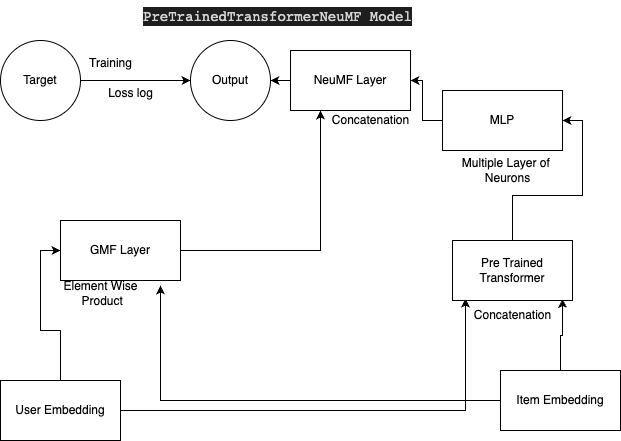

Since here we are using pretrained Transformer, hence there is no need to designed separately attention layer with (k,q,v) matrices, unlike as done in previous model.

In [3]:
class PreTrainedTransformerNeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(PreTrainedTransformerNeuMF, self).__init__()
        self.factor_num_gmf = args.factor_num #64
        self.factor_num_mlp =  int(args.mlp_layers[0]/2) #64/2= 32
        self.mlp_layers = args.mlp_layers #[64,32,16,8]
        self.attention_layers = args.attention_layers

        self.user_mf_embedding = nn.Embedding(num_users, self.factor_num_gmf)
        self.item_mf_embedding = nn.Embedding(num_items, self.factor_num_gmf)

        self.user_mlp_embedding = nn.Embedding(num_users, self.factor_num_mlp)
        self.item_mlp_embedding = nn.Embedding(num_items, self.factor_num_mlp)

        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.factor_num_mlp * 2, nhead=self.attention_layers['nhead'])
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=self.attention_layers['num_layers'])

        self.mlp = nn.Sequential()
        mlp_input_dim = (self.factor_num_mlp) * self.attention_layers['num_layers']
        for i in range(len(self.mlp_layers)):
            self.mlp.add_module(f"linear{i}", nn.Linear(mlp_input_dim, self.mlp_layers[i]))
            self.mlp.add_module(f"relu{i}", nn.ReLU())
            self.mlp.add_module(f"dropout{i}", nn.Dropout(0.2))
            mlp_input_dim = self.mlp_layers[i]

        self.output = nn.Linear(self.factor_num_gmf + self.mlp_layers[-1], 1)

    def forward(self, user_ids, item_ids):
        user_mf_embeds = self.user_mf_embedding(user_ids)
        item_mf_embeds = self.item_mf_embedding(item_ids)

        user_mlp_embeds = self.user_mlp_embedding(user_ids)
        item_mlp_embeds = self.item_mlp_embedding(item_ids)

        mf_interaction = torch.mul(user_mf_embeds, item_mf_embeds)

        mlp_interaction = torch.cat((user_mlp_embeds, item_mlp_embeds), dim=1)
        mlp_interaction = mlp_interaction.unsqueeze(1)

        attention_out = self.transformer_encoder(mlp_interaction)
        attention_out_flat = attention_out.view(attention_out.size(0), -1)

        mlp_out = self.mlp(attention_out_flat)

        concat_out = torch.cat((mf_interaction, mlp_out), dim=1)

        rating_pred = self.output(concat_out)

        return rating_pred.squeeze()

***Task 2: ***

I do not feel there is any need to update or change the existing Data structures (Dataset and DataLoader) to handle the input data. Hence, I am using the existing preprocessing steps and also the existing evaluation metrics, which are HR(Hit ratio) and NDCG(Normalized Distributed Cumulative Gain)

***Task 3:***

After training both the models shown above and tuning the "attention hyperparameter" (no of heads) the below is my analysis:

As it is visible both models are giving HR of 0.526 just after training both of them for 15 epochs only. 

The best model of previous lab challenges was obtained when we used "Transfer Learning" for neuMF, which yielded a HR(Hit Ratio) of 0.506 (Please refer to [Lab Challenge 2](https://colab.research.google.com/drive/1tv8rHEwJhZoij_X1yHfysPq0VxPlXf92#scrollTo=2fmdAPSgiwGr) to confirm). Thus we are seeing the performance of the model increases by **3.9% ~4%** just by adding attention mechanism, which indeed is quite significant.

Thus proving that attention mechanism definitely enhances the performance of the model.

Training model_Transformer ...

 Training epoch 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


-- train loss 0.141

 epoch 0
-- train loss 0.141, validation loss 0.117
HR: 0.413	NDCG: 0.218

 Training epoch 1
-- train loss 0.118
HR: 0.391	NDCG: 0.204

 Training epoch 2
-- train loss 0.116
HR: 0.400	NDCG: 0.206

 Training epoch 3
-- train loss 0.114
HR: 0.413	NDCG: 0.217

 Training epoch 4
-- train loss 0.111
HR: 0.442	NDCG: 0.239

 Training epoch 5
-- train loss 0.108

 epoch 5
-- train loss 0.108, validation loss 0.102
HR: 0.443	NDCG: 0.249

 Training epoch 6
-- train loss 0.104
HR: 0.466	NDCG: 0.248

 Training epoch 7
-- train loss 0.1
HR: 0.463	NDCG: 0.235

 Training epoch 8
-- train loss 0.0965
HR: 0.463	NDCG: 0.255

 Training epoch 9
-- train loss 0.0929
HR: 0.480	NDCG: 0.256

 Training epoch 10
-- train loss 0.0895

 epoch 10
-- train loss 0.0895, validation loss 0.0825
HR: 0.490	NDCG: 0.278

 Training epoch 11
-- train loss 0.0861
HR: 0.515	NDCG: 0.280

 Training epoch 12
-- train loss 0.0832
HR: 0.514	NDCG: 0.274

 Training epoch 13
-- train loss 0.0803
HR: 0.517	NDCG: 0

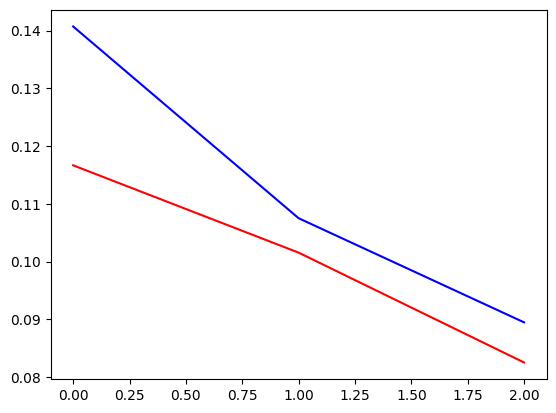

Loss Diff -0.012323256238050034
Training modelSelfAttention ...

 Training epoch 0
-- train loss 0.132

 epoch 0
-- train loss 0.132, validation loss 0.114
HR: 0.400	NDCG: 0.217

 Training epoch 1
-- train loss 0.114
HR: 0.392	NDCG: 0.215

 Training epoch 2
-- train loss 0.113
HR: 0.388	NDCG: 0.215

 Training epoch 3
-- train loss 0.112
HR: 0.389	NDCG: 0.217

 Training epoch 4
-- train loss 0.11
HR: 0.415	NDCG: 0.237

 Training epoch 5
-- train loss 0.106

 epoch 5
-- train loss 0.106, validation loss 0.104
HR: 0.462	NDCG: 0.261

 Training epoch 6
-- train loss 0.103
HR: 0.489	NDCG: 0.273

 Training epoch 7
-- train loss 0.101
HR: 0.507	NDCG: 0.278

 Training epoch 8
-- train loss 0.1
HR: 0.516	NDCG: 0.285

 Training epoch 9
-- train loss 0.0993
HR: 0.526	NDCG: 0.291

 Training epoch 10
-- train loss 0.0989

 epoch 10
-- train loss 0.0989, validation loss 0.0975
HR: 0.520	NDCG: 0.287

 Training epoch 11
-- train loss 0.0985
HR: 0.525	NDCG: 0.292

 Training epoch 12
-- train loss 0.0982

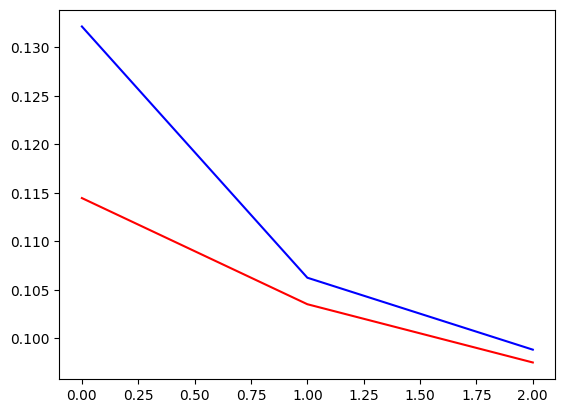

Loss Diff -0.007240193192169231


In [ ]:
args = parser.parse_args("")
modelTransformer = PreTrainedTransformerNeuMF(args, num_users, num_items)
modelSelfAttention = SelfAttentiveNeuMF(args, num_users, num_items)
model_dict = {'model_Transformer': modelTransformer}
model_dict['modelSelfAttention']= modelSelfAttention
args = parser.parse_args("")


for model in model_dict.keys():
  print('Training {} ...'.format(model))
  criterion = nn.MSELoss(reduction = 'mean')
  optimizer = torch.optim.Adam(model_dict[model].parameters(), lr=args.lr)

  tr_loss, va_loss = [], []

  for epoch in range(args.epochs):
    print(f'\n Training epoch {epoch}')
    tr_loss_step = training_step(model_dict[model], criterion = criterion, optimizer = optimizer)
    print(f'-- train loss {tr_loss_step:.3}')
    if epoch % 5 == 0:
      va_loss_step = validation_step(model_dict[model], criterion = criterion, optimizer = optimizer)
      va_loss.append(va_loss_step)
      tr_loss.append(tr_loss_step)
      print(f'\n epoch {epoch}')
      print(f'-- train loss {tr_loss_step:.3}, validation loss {va_loss_step:.3}')
    HR, NDCG = metrics(model_dict[model], test_loader, args.top_k, device)
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))


  plot_loss(tr_loss, va_loss)
  loss_diff = np.array(va_loss)- np.array(tr_loss)
  print('Loss Diff', np.mean(loss_diff[-10:]))